# F21NL 2025-26: Ngram Language Modeling, Gradients and Activation Functions

Content of this tutorial is delivered during the 'F20NL/F21NL - Introduction to Natural Language Processing' course at Heriot-Watt University.

## Scope of the Lab

**Recap from Bi-gram Language Modeling Lab**

In the previous introduction to PyTorch we developed a Bi-gram character-level language model. We approached this by looking at only the single previous character and predicting the probability distribution of the character that follows in the sequence.

We did that by computing all counts in our dataset and converting these counts into probabilities:

<div align="center">

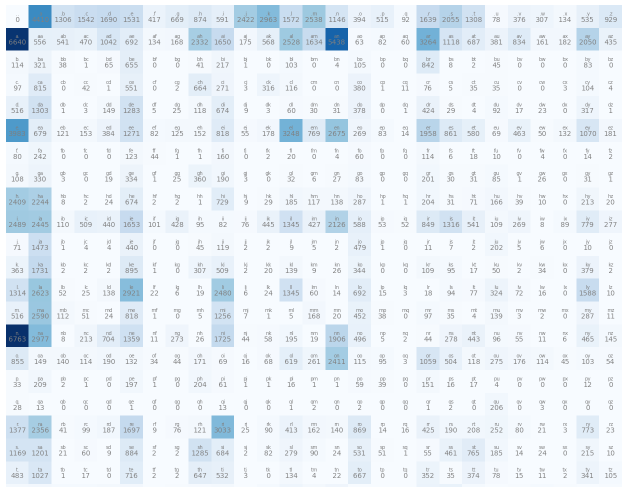

However, the predictions of this model were not very good, because we were only taking into account one character as context. **Can we just take more context?**

The problem is that this table is not practically scalable when increasing the context length, **why**? For a single character at a time we saw that we have 27 different outcomes for the next character.  

**Question:** Let's imagine now we take two characters as input and try to predict the third one. How many rows will the table contain?

<details>
<summary><strong>Answer</strong></summary>

We have in total 27 possible characters for the first character, and 27 possible characters for the second character so in total we would need $27 \times 27 = 729$ rows to predict the third character.

So in general, assuming a context window of size $N$ we would require $27^N$ rows to represent all possible outcomes!


So clearly, we need something more scalable if we are to take into account more context.




In this lab we are going to improve our bi-gram language model that we previously developed by adopting concepts from the [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).

More specifically:
- We are going to implement the neural network proposed in the original paper and is illustrated below
- We are going to see how the effect of weight initialization can prevent gradients flowing from the model
- We are going to implement Batch Normalization, a modification on top of this neural network to further address the problem of gradient flow. This will be the foundational building block that we are going to use moving towards sequence-to-sequence models.

<div align="center">

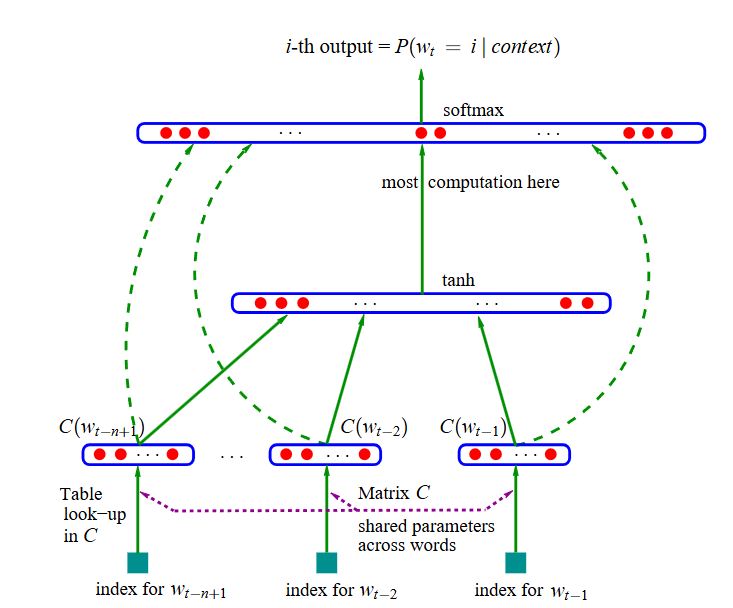

---

### Summary of the core ideas / steps from the paper that we will adopt moving on:

- Keep in mind that the original paper builds a **word-level** language model, i.e the model accepts some previous words as context, and predicts the next word that follows. For pure educational reasons, we are going to stick to our own **character-level** model but we will follow the same modeling approach.

- The original paper uses a vocabulary of 17,000 words and associates them with a feature vector (a word-embedding as we saw in the gensim lab), denoted as $C$ in the figure. This $C$ is essentially a look-up table that retrieves the vector for each word in the vocabulary. During training these vectors are updated, in a way that it becomes easier for the model to predict the next word. As a result, similar words will have similar vector representations -- just as we asw in our gensim lab where we applied PCA on the GloVe embeddings.

- The model is essentially a Multi-Layer Percepton (MLP) that takes as input the two previous words and tries to predict the 3rd word. The look-up table $C$ is shared between all words, so basically we are using the same matrix $C$ to retrieve the word vectors. Next up the word vectors are concatenated and passed through a hidden layer with a  `tanh` activation function, and the output of that hidden layer is converted into probabilities for the next word.


- The authors trained the model by maximizing the log-likelihood (or equivanetly, minize the negative log-likelihood as we saw in our previous labs).  **Ignore the green dashed lines as they describe variations of the model that do not care about at the present moment.**

-------

**Why does this work**?

Imagine the model is trained on the following sentences:

- The cat is walking in the bedroom
- A dog was running in a room

If the model puts close in the embedding space similar words like animals (dog, cat) and it can potentially generalize, by transfering knowledge, to sentences like:

- The cat is running in a room

Most of the code that we have implemented so far is for understanding the underlying machinery.

**Today, along with the playground code, we are going to introduce the proper way of developing such models using PyTorch**

In [ ]:
!pip install torch numpy matplotlib -U

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt -O names.txt

words = open('names.txt', 'r').read().splitlines()

In [ ]:
words[:10]

In [ ]:
# Load the dataset that we used in the previous lab
def prepare_vocabulary(
    words: list[str], start_character: str = "<S>", end_character: str = "<E>"
) -> tuple[dict[str, int], dict[int, str]]:
    """Prepare the vocabulary from the list of names.

    Params:
        words (list[str]): A list of strings corresponding to names of our dataset
        start_character (str): The special starting character for a name
        end_character (str): The special ending character for a name

    Returns:
        chara2idx (dict[str, int]): A dictionary that maps characters to indices in the vocabulary
        idx2chara (dict[int, str]): A dictionary that maps indices to characters in the vocabulary
    """
    chars = sorted(list(set(''.join(words))))
    chara2idx = {s:i+1 for i,s in enumerate(chars)}

    # For convience, assign the start_character as the 1st character in the vocabulary
    chara2idx[start_character] = 0

    if end_character not in chara2idx:
        # For convenience, assign the end_character as the last character in the vocabulary
        chara2idx[end_character] = len(chars) + 1

    # Also create the inverse mapping for later use, i.e from integers to characters
    idx2chara = {i:s for s,i in chara2idx.items()}
    print(chara2idx)
    return chara2idx, idx2chara

chara2idx, idx2chara = prepare_vocabulary(words=words, start_character=".", end_character=".")

In [ ]:
def prepare_inputs_outputs(
    words: list[str],
    chara2idx: dict[str, int],
    idx2chara: dict[int, str],
    context_length: int = 3,
    start_chara: str = ".",
    end_chara: str = ".",
) -> tuple[torch.Tensor, torch.Tensor]:
    """Prepare the inputs/outputs for our model.

    Params:
        words (list[str]): A list of strings corresponding to names of our dataset
        chara2idx (dict[str, int]): A dictionary that maps characters to indices in the vocabulary
        idx2chara (dict[int, str]): A dictionary that maps indices to characters in the vocabulary
        context_length (int): The context of our model. A context length of L means that the model
            accepts L characters as input and predicts the L+1 character.
    Returns:
        inputs (torch.Tensor): The inputs of the model for the entire dataset (num_examples, context_length - 1)
        labels (torch.Tensor): The labels that the model needs to predict for each example (num_examples, 1)
    """
    inputs = []
    labels = []
    for word in words:
        # Create a padded context that we are going to populate
        context = [chara2idx[start_chara]] * context_length
        for chara in f"{word}{end_chara}":
            chara_token_id = chara2idx[chara]
            # The input is the current context
            inputs.append(context)
            # The target to predict given the current context is the `chara_token_id`
            labels.append(chara_token_id)

            # Prepare the context for the next iteration.
            # Shift the context by one
            context = context[1:]
            # Append the current chara_token_id, as will be included in the context for the next iteration
            context.append(chara_token_id)

    return torch.tensor(inputs), torch.tensor(labels)

In [ ]:
# Lets see a couple of examples that were created from the firt word
context_length = 3
inputs, labels = prepare_inputs_outputs(
    words=words, chara2idx=chara2idx, idx2chara=idx2chara, context_length=context_length, start_chara=".", end_chara="."
)

print(words[0])
for input, label in zip(inputs[:5], labels[:5]):
    print(
        " ".join([idx2chara[token] for token in input.tolist()]),  "-->" "".join([idx2chara[label.item()]])
    )
    print(input.tolist(), "-->", label.tolist())
    print("----")

So the word `emma` produces 5 examples:

1. given the context `...` we need to predict `e`,
2. given the context `..e` we need to predict `m`

and so on



## Implementing the look-up table

The look-up table $C$ contains embeddings for our vocabulary. So we have $27$ possible characters, and we represent them with an embedding vector of dimensionality `embedding_dim`.

In [ ]:
# Randomly initialize the look-up table C
num_characters = len(chara2idx)
embedding_dim = 2
print(f"Total number of characters: {num_characters}")
# Each character in our vocabulary is represented by a 2D vector
C = torch.randn((num_characters, embedding_dim))

In [ ]:
# Indexing the look-up table to find the vector for a character
character_token_id = 5
print(C[character_token_id])

# An seamingly different but identical way of indexing the table:
# One-hot encoding from our previous labs
one_hot_encoding = F.one_hot(torch.tensor(character_token_id), num_classes=num_characters).to(dtype=torch.float)
print(one_hot_encoding)
# Pulling the 5th column from the look-up table
print(one_hot_encoding @ C)

In [ ]:
# Lets use a subset of the inputs for now
inputs = inputs[:32]
labels = labels[:32]

# (32, 3): 32 examples, 3 context length
print(inputs.shape)

# Indexing the look-up table, (32, 3) -> (32, 3, 2)
# 32 examples, 3 characters in context, 2-d vector for every word in context
print(C[inputs].shape)

### Implementing the look-up table the Torched Way!

Looking at top figure, we can intepret $C$ as:

- Lookup table where we use the `character_token_id` to index its vector

- A **linear layer** of the model. This layer has neurons that have no linearity, and their weight matrix is $C$. We are then using one-hot-encoding and feeding them into the neural layer.

This linear layer is commonly referred to as the **embedding layer** of the model.

A simple embedding layer is implemented in PyTorch using [nn.Embedding](https://docs.pytorch.org/docs/stable/generated/torch.nn.Embedding.html)

In [ ]:
# Create an Embedding Layer with `num_characters` randomly initialized 2D vectors
embedding_layer = torch.nn.Embedding(num_embeddings=num_characters, embedding_dim=embedding_dim)
# Assign the vectors to be equal to C just for demonstration purposes
embedding_layer.weight = torch.nn.Parameter(C)

# Get the embedding vectors from the layer
embedded_inputs = embedding_layer(inputs)

# Verify that the look-up table and the embedding views are the same
if not torch.allclose(embedded_inputs, C[inputs]):
    raise AssertionError("Oh no!, the embedded inputs are not identical to look-up indexing")

print("All good!")

## Implementing the hidden layer

Lets continue by implementing the hidden layer. This layer accepts as input the **concatenated** context, i.e all embedding vectors stacked together.

In the above example we have 3 characters as context, and each character has a 2D vector, so the layer expects an input of $3 \times 2$ numbers. The output of the layer is a **hyperpameter**, a variable that is up to us to specify that is tailored to the design of the model.

Additionally, the output of the hidden layer is passed through a `tanh` activation function:

In [ ]:
output_dim = 100
W1 = torch.randn((context_length * embedding_dim, output_dim))
b1 = torch.randn(output_dim)
print(W1.shape, b1.shape)

In [ ]:
# (32, 3, 2)
embedded_vectors = C[inputs]
# Concatenate the vectors (32, 3, 2) -> (32, 6).
# We could use 6 instead of -1 here to let pytorch infer the last dimension
# But in general putting magic numbers randomly in your code is bad
embedded_input = embedded_vectors.view(embedded_vectors.shape[0], -1)

output = embedded_input @ W1 + b1
output_tanh = torch.tanh(output)

### Implementing the linear layer the Torched Way!

A simple linear layer is implemented in PyTorch using [nn.Linear](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)

In [ ]:
# Create a linear layer with input_features=context_length * embedding_dim and out_features=output_dim
layer = torch.nn.Linear(in_features=context_length * embedding_dim, out_features=output_dim, bias=True)
tanh_activation = torch.nn.Tanh()
# Assign the W1 to the weights of the layer just for demonstration purposes
layer.weight = torch.nn.Parameter(W1.T)
# Assign the b1 to the bias of the layer just for demonstration purposes
layer.bias = torch.nn.Parameter(b1)

# Get the output from the layer
output_layer = layer(embedded_input)
output_layer_tanh = tanh_activation(output_layer)

# Verify that the two views are the same
if not torch.allclose(output_tanh, output_layer_tanh):
    raise AssertionError("Oh no!, the outputs from the linear layer are not identical")

## Implementing the output layer

The last component is the output layer. Note that it accepts the output from the hidden layer and we expect it to output class probabilities for each character.

In [ ]:
W2 = torch.randn((output_dim, num_characters))
b2 = torch.randn(num_characters)

logits = output_tanh @ W2 + b2

## Implementing the Negative log-likehood


In [ ]:
# Same as the previous labs
def compute_nll(logits: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    """Compute the negative log-likelihood"""
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    # Get the probability assigned by the network for each label
    label_probs = probs[torch.arange(logits.shape[0]), labels]
    # Log + Average
    likelihood = label_probs.log().mean()
    loss = -likelihood
    return loss

nll = compute_nll(logits=logits, labels=labels)
print(nll)

### Implementing the Negative log-likehood the Torched Way!

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
loss = loss_function(logits, labels)

if not torch.allclose(nll, loss):
    raise AssertionError("Oh no the loss values are not identical!")

**But why should I implement everything in torched-like format?**

Unless you have a very specific reason, do not built something from scratch that is supported by the library. The library already has been heavily optimized and it is very likely that their implementation is better than yours. Lets take as an example the CrossEntropy loss:

1. The `compute_nll` creates a bunch of tensors that takes redundant memory space. PyTorch will make all these operations efficienctly but also actual optimization of the loss value is much easier because it uses simple mathematical operations
2. The `CrossEntropyLoss` is behaves significantly better than the `compute_nll` above.

Try the following:

In [ ]:
logits = torch.tensor([-2, -3, 0, 5])
counts = logits.exp()
probs = counts / counts.sum()
# This should be ok
print(1, counts)
print(2, probs)

# Lets try some more extreme logits
logits = torch.tensor([-100, -3, 0, 5])
counts = logits.exp()
probs = counts / counts.sum()
# This should be ok though the first probability is a bit sketchy
print(3, counts)
print(4, probs)


logits = torch.tensor([-100, -3, 0, 100])
counts = logits.exp()
probs = counts / counts.sum()
# What about this one? Oh no....
print(5, counts) # We ran out of precision range because we did e^100
print(6, probs)

# So we cannot pass large logits but what does CrossEntropy do under the hood?
logits = torch.tensor([-100, -3, 0, 5])
# Observe that we normalize by the sum of the counts and so we can offset by w/e we want
# So we can add/subtract WHATEVER constant that we want in the logits without affecting the probs
counts = logits.exp()
probs = counts / counts.sum()
print(7, counts)
print(8, probs)

logits = torch.tensor([-100, -3, 0, 5])
logits -= logits.max()
counts = logits.exp()
probs = counts / counts.sum()
# prints 8 must be the same as print 10 even though the counts are different
print(9, counts)
print(10, probs)

# TLDR: do not fall in love with your and use the built-in functions unless you have a good reason not to

## Putting all the model components together

In [ ]:
context_length = 3
inputs, labels = prepare_inputs_outputs(
    words=words, chara2idx=chara2idx, idx2chara=idx2chara, context_length=context_length, start_chara=".", end_chara="."
)

num_characters = len(chara2idx)
embedding_dim = 2
hidden_dim = 100
learning_rate = 0.1

generator = torch.Generator().manual_seed(2147483647)

def prepare_model(
    context_length: int, num_characters: int, embedding_dim: int, hidden_dim: int, generator: torch.Generator,
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """Prepare the model."""
    C = torch.randn((num_characters, embedding_dim), generator=generator)
    print(C.shape)

    W1 = torch.randn((context_length * embedding_dim, hidden_dim), generator=generator)
    b1 = torch.randn(hidden_dim, generator=generator)
    print(W1.shape, b1.shape)

    W2 = torch.randn((hidden_dim, num_characters), generator=generator)
    b2 = torch.randn(num_characters, generator=generator)
    print(W2.shape, b2.shape)

    total_parameters = [C, W1, b1, W2, b2]

    # Make all parameters trainable
    for p in total_parameters:
        p.requires_grad = True

    return [C, W1, b1, W2, b2]

In [ ]:
def gradient_descent(
    inputs: torch.Tensor,
    labels: torch.Tensor,
    learning_rate: float = 0.1,
    num_iterations: int = 1000,
    print_loss_per_step: bool = False,
) -> torch.Tensor:
    """Performs the gradient-descent algorithm.

    Params:
        inputs (torch.Tensor): The inputs to the model
        labels (torch.Tensor): The expected predictions for each input example
        learning_rate (float): The learning rate used in the update rule of GD
        num_iterations (int): The number if iterations to run
        print_loss_per_step (bool): Whether to print the loss for each iteration

    Returns:
        loss: (torch.Tensor): The loss after the final iteration
    """
    for _ in range(num_iterations):
        # Forward pass
        # Step 1: Embed the inputs
        embeddings = C[inputs]
        # Step 2: Pass them through the hidden layer
        hidden = torch.tanh(embeddings.view(embeddings.shape[0], -1) @ W1 + b1)
        # Step 3: Obtain the logits
        logits = hidden @ W2 + b2
        # Step 4: Compute the loss function
        loss = F.cross_entropy(logits, labels)
        if print_loss_per_step:
            print(loss)

        # Backward pass
        # Step 1: Iterate over all parameters and set gradient to None
        for p in total_parameters:
            p.grad = None

        # Step 2: Back-propagate the loss
        loss.backward()

        # Step 3: Update
        for p in total_parameters:
            p.data += -learning_rate * p.grad

    return loss

generator = torch.Generator().manual_seed(2147483647)
(C, W1, b1, W2, b2) = prepare_model(
    context_length=context_length,
    num_characters=num_characters,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    generator=generator,
)
total_parameters = [C, W1, b1, W2, b2]

# Lets try to train on only 32 examples
gradient_descent(inputs=inputs[:32], labels=labels[:32], learning_rate=0.1, num_iterations=100, print_loss_per_step=False)

**Question**: Wooah the loss is incredibly low! Could we actually reach a loss of 0?

<details>
<summary><strong>Answer</strong></summary>

Not really, there are examples that have identical context window but have a different label. So we are giving the same input and expect the model to predict different things. Can you think which examples in the dataset have identical contexts but different labels?



## Training on the whole dataset

In [ ]:
generator = torch.Generator().manual_seed(2147483647)
(C, W1, b1, W2, b2) = prepare_model(
    context_length=context_length,
    num_characters=num_characters,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    generator=generator,
)

total_parameters = [C, W1, b1, W2, b2]

gradient_descent(inputs=inputs, labels=labels, learning_rate=0.1, num_iterations=100, print_loss_per_step=True)

### Mini-batch gradient descent

You most likely noticed that the optimization process is quite slow. We started with a very high loss and while the loss is coming down, it takes quite a bit of time to iterate over the whole dataset, compute the exact gradient over the whole dataset, then update the model parameters.

In practice what people do is a mini-batch gradient optimization. We perform forward and backward passes on many batches of data. So we want to select a small portion of data every time, perform forward/backward pass and then update the model parameters based on that small example.

In [ ]:
# Create mini-batches of data
batch_size = 32
torch.randint(0, inputs.shape[0], (batch_size, ))

In [ ]:
def gradient_descent_mini_batch(
    inputs: torch.Tensor,
    labels: torch.Tensor,
    learning_rate: float = 0.1,
    num_iterations: int = 1000,
    batch_size: int = 32,
    generator: torch.Generator | None = None,
    print_loss_per_step: bool = False,
) -> torch.Tensor:
    """Performs the gradient-descent algorithm with min-batches.

    Params:
        inputs (torch.Tensor): The inputs to the model
        labels (torch.Tensor): The expected predictions for each input example
        learning_rate (float): The learning rate used in the update rule of GD
        num_iterations (int): The number if iterations to run
        batch_size (int): The size of the mini batch
        generator (torch.Generator): A generator used to sample batches deterministically
        print_loss_per_step (bool): Whether to print the loss for each iteration

    Returns:
        loss: (torch.Tensor): The loss after the final iteration
    """
    for _ in range(num_iterations):
        batch_indices = torch.randint(0, inputs.shape[0], (batch_size, ), generator=generator)
        batch_inputs = inputs[batch_indices]
        batch_labels = labels[batch_indices]

        # Forward pass
        # Step 1: Embed the inputs
        embeddings = C[batch_inputs]
        # Step 2: Pass them through the hidden layer
        hidden = torch.tanh(embeddings.view(embeddings.shape[0], -1) @ W1 + b1)
        # Step 3: Obtain the logits
        logits = hidden @ W2 + b2
        # Step 4: Compute the loss function
        loss = F.cross_entropy(logits, batch_labels)
        if print_loss_per_step:
            print(loss)

        # Backward pass
        # Step 1: Iterate over all parameters and set gradient to None
        for p in total_parameters:
            p.grad = None

        # Step 2: Back-propagate the loss
        loss.backward()

        # Step 3: Update
        for p in total_parameters:
            p.data += -learning_rate * p.grad

    return loss

generator = torch.Generator().manual_seed(2147483647)
(C, W1, b1, W2, b2) = prepare_model(
    context_length=context_length,
    num_characters=num_characters,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    generator=generator,
)

total_parameters = [C, W1, b1, W2, b2]

gradient_descent_mini_batch(
    inputs=inputs,
    labels=labels,
    learning_rate=0.1,
    num_iterations=10000,
    batch_size=32,
    generator=generator,
    print_loss_per_step=True,
)

Note that the optimization process is actually much faster now! But importantly the gradient that we compute over a small set of examples and so the quality of the gradient is lower. The direction that we have derived is not the actual direction obtained from computing the gradient across all examples but it is good enough to be useful!

**It is much better to run multiple optimization steps on an estimate of the true gradient, than to evaluate the exact gradient and take fewer steps**

----

We said earlier that when we have a lower loss, essentially we have a better model. And this happens to be the case here as we are achieving a loss that it is much lower than the bi-gram model that we developed in the previous labs. **This is not exactly true**.

As the capacity of the neural network grows, it becomes more and more likely that it overfits on the training set (see [here](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff)). This means that the training loss will become incredibly small but in practice the model memorizes the training examples.

So if we take this pressumably good model and sample from it, we will only get examples identical to the ones in the training set (quite boring). Additionally, if we have some held-out names, that the model has never seen before, the loss can be disproportionally high.

The standard approach in NLP is to split our data into training, development (or validation), and test split:
- Training data is used to optimize the actual parameters (weights) of the model
- Development data is used to optimize the hyperparameters of the model (for example the `hidden_dim`, or the `embedding_dim`)
- Test data is the data that we use to evaluate our model. Once we find the best performing model, in terms of validation performance, we use that model on the test set. **We evaluate on the test set very few times, because every time we do that, we learn something from it, and so we "train" on this test split.**


In [ ]:
import random
random.seed(42)
random.shuffle(words)

context_length = 3

# 80% of data for training
n1 = int(0.8 * len(words))
# 10% of data for validation, rest test
n2 = int(0.9 * len(words))

inputs_train, labels_train = prepare_inputs_outputs(
    words=words[:n1], chara2idx=chara2idx, idx2chara=idx2chara, context_length=context_length, start_chara=".", end_chara="."
)

inputs_validation, labels_validation = prepare_inputs_outputs(
    words=words[n1:n2], chara2idx=chara2idx, idx2chara=idx2chara, context_length=context_length, start_chara=".", end_chara="."
)

inputs_test, labels_test = prepare_inputs_outputs(
    words=words[n2:], chara2idx=chara2idx, idx2chara=idx2chara, context_length=context_length, start_chara=".", end_chara="."
)

## Exercise 1: Experiment with different configurations of the neural network

- Try to find a good set of hyperparameters (by modifying the size of the network or adjusting the training hyperparameters like the `learning_rate`, and `num_iterations`).
- Once you have a good loss on the validation set, evaluate the same model on the test set.

In [ ]:
num_characters = len(chara2idx)
embedding_dim = 2
hidden_dim = 100
learning_rate = 0.1

generator = torch.Generator().manual_seed(2147483647)
(C, W1, b1, W2, b2) = prepare_model(
    context_length=context_length,
    num_characters=num_characters,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    generator=generator,
)

total_parameters = [C, W1, b1, W2, b2]

gradient_descent_mini_batch(
    inputs=inputs_train,
    labels=labels_train,
    learning_rate=0.1,
    num_iterations=10000,
    batch_size=32,
    generator=generator,
    print_loss_per_step=False,
)

In [ ]:
# Evaluate on validation
embeddings = C[inputs_validation]
hidden = torch.tanh(embeddings.view(embeddings.shape[0], -1) @ W1 + b1)
logits = hidden @ W2 + b2
loss = F.cross_entropy(logits, labels_validation)
print(loss)

In [ ]:
# Evaluate on test
embeddings = C[inputs_test]
hidden = torch.tanh(embeddings.view(embeddings.shape[0], -1) @ W1 + b1)
logits = hidden @ W2 + b2
loss = F.cross_entropy(logits, labels_test)
print(loss)

## Sampling from the model

In [ ]:
generator = torch.Generator().manual_seed(2147483647)
num_samples = 20
context_length = 3
end_character = "."

for _ in range(20):
    out = []
    context = [0] * context_length
    while True:
        embedding = C[torch.tensor([context])]
        hidden = torch.tanh(embedding.view(1, -1) @ W1 + b1)
        logits = hidden @ W2 + b2
        probs = torch.nn.functional.softmax(logits, dim=1)
        sampled_character_id = torch.multinomial(probs, num_samples=1, generator=generator).item()
        context = context[1:] + [sampled_character_id]
        out.append(sampled_character_id)
        if sampled_character_id == chara2idx[end_character]:
            break

    print("".join([idx2chara[chara_id] for chara_id in out]))


## Exercise 2: Torchifying the model

We have now fully developed our neural N-gram Model. Moving on we will use code that looks like more production-level pytorch.

In general, the common practice is to organize your model as a class that inherits from the [nn.Module](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html). Importantly, everything within the model that we have used so far is also a class that inherits from the nn.Module.

When we create a neural model we need to implement two methods:

- First, the **`__init__`** which will initialize all the sub-modules of our model.
- Second, the **`forward`** method of our model, where the magic happens. Within the forward method the input is transformed sequentially to produce the output. **The forward method is executed every time the module is called.**


Implement these two functions, if you find it challenging, look up to the sections where we converted some of our code to more PyTorch-like modules.

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

class SimpleNet(nn.Module):
    def __init__(self,
        context_length: int = 3, vocab_size: int = 27, embedding_dim: int = 2, hidden_dim: int = 100, num_classes: int = 27
    ) -> None:
        super().__init__()
        # Store any information that we may need after construction
        self.context_length = context_length
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes

        # Create the embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Fully connected hidden layer
        self.hidden_layer = nn.Linear(context_length * embedding_dim, hidden_dim)
        # Create the tanh activation
        self.tanh_activation = torch.nn.Tanh()
        # Output classification layer (e.g num_classes)
        self.classification = nn.Linear(hidden_dim, num_classes)

    def forward(
        self, input_ids: torch.Tensor, labels: torch.Tensor | None = None
    ) -> tuple[torch.Tensor, torch.Tensor | None]:
        """Forward pass of our network.

        Args:
            input_ids (torch.Tensor): The input token ids to the model of shape (batch_size, context_length)
            labels (torch.Tensor): Optionally, the labels for each example in our input of shape (batch_size)

        Returns:
            logits (torch.Tensor): The logits after passing the input ids
            loss (torch.Tensor | None): The loss computed over all examples if the labels are provided.
        """
        logits, loss = None, None
        raise NotImplementedError("You need to implement the forward pass, see the step-by-step instructions")
        # Step 1: Embed the inputs

        # Step 2: Pass the embeddings through the hidden layer,
        # you will need to reshape the embeddings to match the input size of the hidden layer (see the init)

        # Step 3: Pass the outputs through the tanh activation

        # Step 4: Obtain the logits

        # Step 4: Compute the loss if the labels are not None
        return logits, loss

### Verify your implementation by comparing the expected loss on the validation


In [ ]:
# DO NOT MODIFY THIS
num_characters = len(chara2idx)
embedding_dim = 2
hidden_dim = 100

# nn.Modules dont accept a generator to initialize the weights
# Fix the seeding beforehand
torch.manual_seed(2147483647)

my_awesome_model = SimpleNet(
    vocab_size=num_characters,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_classes=num_characters,
)


with torch.no_grad():
    _, loss_validation = my_awesome_model(input_ids=inputs_validation, labels=labels_validation)
    assert torch.allclose(loss_validation, torch.tensor(3.277365207672119))

## Torchifying the training

Previously we iterated ourselves over the model's parameters to update them according to: $p = -lr * p.grad$

This was easy because our update rule is quite straightforward, and the model is quite simple. In practice, though the update rule can be more complicated with additional terms, and the model will most certaintly be more complicated.

So instead of writing the optimization step ourselves, PyTorch provides built-in optimizers. In this example we are going to use the [SGD optimizer](https://docs.pytorch.org/docs/stable/generated/torch.optim.SGD.html) which implements the Stochastic Gradient Descent approach -- the one we also implemented with minibatches!


In [ ]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(my_awesome_model.parameters(), lr=0.001)

Below is a generic training function using pure PyTorch. For every iteration:

- Step 1: Sample a batch of examples from our data
- Step 2: Zeros the optimizer's gradients -- each update rule depends on only a single mini batch
- Step 3: Perform a forward pass, that is compute the predictions and the loss from the model
- Step 4: Calculate the backward gradients over the learnable parameters (`loss.backward()`)
- Step 5: Tell the optimizer to perform one learning step. Use the SGD update rule to adjust the weights of the model based on the observed gradients within the bach.


Finally, it reports the average per-batch loss for every 100 batches

In [ ]:
def train(
    inputs: torch.Tensor,
    labels: torch.Tensor,
    model: SimpleNet,
    optimizer: torch.optim.SGD,
    num_iterations: int,
    print_every: int = 100,
) -> None:
    """Train a SimpleNet model.

    Params:
        inputs (torch.Tensor): The inputs to the model
        labels (torch.Tensor): The expected predictions for each input example
        model (SimpleNet): The model that we are trying the train
        optimizer (torch.optim.SGD): A Stochastic Gradient Descent Optimizer
        num_iterations (int): The number of iterations to run
        print_every (int): Print the loss ever `print_every` iterations
    """
    model.train()

    for iteration in range(num_iterations):
        # Prepare a batch
        batch_indices = torch.randint(0, inputs.shape[0], (batch_size, ))
        batch_inputs = inputs[batch_indices]
        batch_labels = labels[batch_indices]

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Forward pass: computing predictions and loss
        predictions, loss = model(input_ids=batch_inputs, labels=batch_labels)

        # Backward pass
        # Compute the all gradients
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Report the loss every `print_every` iterations, also print the starting loss
        if iteration == 0 or iteration % print_every == (print_every - 1):
            print(f"  batch {iteration + 1} loss: {loss.item()}")

In [ ]:
import random
random.seed(42)
random.shuffle(words)

# Create mini-batches of data
batch_size = 32
context_length = 3

# 80% of data for training
n1 = int(0.8 * len(words))
# 10% of data for validation, rest test
n2 = int(0.9 * len(words))

inputs_train, labels_train = prepare_inputs_outputs(
    words=words[:n1], chara2idx=chara2idx, idx2chara=idx2chara, context_length=context_length, start_chara=".", end_chara="."
)

inputs_validation, labels_validation = prepare_inputs_outputs(
    words=words[n1:n2], chara2idx=chara2idx, idx2chara=idx2chara, context_length=context_length, start_chara=".", end_chara="."
)

inputs_test, labels_test = prepare_inputs_outputs(
    words=words[n2:], chara2idx=chara2idx, idx2chara=idx2chara, context_length=context_length, start_chara=".", end_chara="."
)

In [ ]:
num_characters = len(chara2idx)
embedding_dim = 10
hidden_dim = 200

# nn.Modules dont accept a generator to initialize the weights
# Fix the seeding beforehand
torch.manual_seed(2147483647)

my_awesome_model = SimpleNet(
    vocab_size=num_characters,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_classes=num_characters,
)

print(my_awesome_model)
num_iterations = 200000
learning_rate = 0.1

# You can also try some different optimization algorithms, such as averaged SGD, Adagrad, or Adam.
# How do your results differ?
optimizer = torch.optim.SGD(my_awesome_model.parameters(), lr=learning_rate)

train(
    inputs=inputs_train,
    labels=labels_train,
    model=my_awesome_model,
    optimizer=optimizer,
    num_iterations=num_iterations,
    print_every=int(num_iterations*0.1)
)

# Evaluate on all data samples after training
# Decorator to disable gradients during inference
# Whatever happens within the `with` statement will not track any gradients
# since we are no longer optimizating the network
with torch.no_grad():
    _, loss_train = my_awesome_model(input_ids=inputs_train, labels=labels_train)
print(loss_train)

In [ ]:
# Evaluate on validation
# Decorator to disable gradients during inference
# Whatever happens within the `with` statement will not track any gradients
# since we are no longer optimizating the network
with torch.no_grad():
    _, loss_validation = my_awesome_model(input_ids=inputs_validation, labels=labels_validation)
    print(loss_validation)

# Evaluate on validation
# Decorator to disable gradients during inference
# Whatever happens within the `with` statement will not track any gradients
# since we are no longer optimizating the network
with torch.no_grad():
    _, loss_test = my_awesome_model(input_ids=inputs_test, labels=labels_test)
    print(loss_test)